# Exercise 1 

## Goal

Understand how to detect a signal embedded in noise and learn how to use `prober`.


## Tasks
1. Plot various realisations of signal plus noise. Use different signal amplitudes with `generate_source` until you can not distinguish the signal because it is too faint. To learn how to use it `generate_source --help`.
1. Learn to use `prober`, our small black box program computing a scalar result based upon input time series and parameter point $(f,\phi)$. For more information use `./prober --help`
1. Learn how `prober` results change, varying the parameters of an injected signal while probing the same parameter point.
1. Plot/document result findings: how large may the mismatch between injection and probed set of parameters become? What happens with weak signals (small amplitude)?
1. Develop a strategy to find a signal using `prober` for a signal with unknown parameters $(A,f,\phi)$.



## Solution

__Task 1__: Plot various realisations of signal plus noise. Use different signal amplitudes with `generate_source` until you can not distinguish the signal because it is too faint. To learn how to use it `generate_source --help`.

__A solution:__ 

* Write a parametrized function that calls `generate_source` with the given paramters and returns the filename of the output datafile. 



In [1]:
# Import some modules
import os
import pandas as pd
import sys
import subprocess
import uuid
import numpy as np

In [2]:
# Create a function to call generate_source with parameters
# First define a variable for the base command and executable path in my
base_cmd = "docker exec -i datalab" # can be empty for local use
exe_dir = "/home/code/" # directory where the executable is found
output_dir = "/home/code/data" # directory to save the data file
data_dir = "../../Codes/data" # directory for jupyter to find the data in

In [53]:
# Call generate source with given parameters
# Have some default values
def generate_source(
    outputFile=None, 
    sigma=0.25, 
    delta_T=None, 
    N=100000,
    f=0, 
    phi=0, 
    A=0, 
    r=0
):
    """
    Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>] [-a <float>] [-r <int>]
      -o, --output=<file>       output file
      -s, --sigma=<float>       standard deviation sigma
      -d, --deltaT=<float>      delta T betwean measurements
      -N, --length=<int>        number of elements
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -a, --amplitude=<float>   signal amplitude
      -r, --random=<int>        if set to 1, generate random signal
      -h, --help                print this help and exit
    """
    if delta_T == None : 
        delta_T = 1/N
    if outputFile == None:
        outputFile = "data_" + str(uuid.uuid4()) + ".csv"
    
    outputPath = os.path.join(output_dir, outputFile) # output_dir + "/" + "myfilename.csv"
    exe_path = os.path.join(exe_dir, 'generate_source')
    cmd_str = f"{base_cmd} {exe_path} -o {outputPath} -s {sigma} "\
        f"-d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    # Optionally print the command line and test it outside the notebook
    print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)

    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print('The process has an output:', out.decode())

    return os.path.join(data_dir, outputFile)

In [54]:
filename = generate_source()

docker exec -i datalab /home/code/generate_source -o /home/code/data/data_c99db96c-0c3a-4f79-9922-fc77f65fffb4.csv -s 0.25 -d 1e-05 -N 100000 -f 0 -p 0 -a 0 -r 0


* Write a function that plots the contents of a file, given the filename

In [5]:
# import plotting lib
import matplotlib.pyplot as plt
# Make the plot nice, more visible
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-paper')

def plot_data(filename, title=None):
    if (not os.path.isfile(filename)):
        if (os.path.isfile(os.path.join(data_dir, filename))):
            filename=os.path.join(data_dir, filename)
        else:
            print(f"File {filename} not found.")
            sys.exit(0)
        
    data = pd.read_csv(filename, header=None, names=['t', 'd'], delimiter=' ')
    data.plot.line('t', 'd')
    plt.xlabel("$t [s]$", fontsize=15)
    plt.ylabel("$d(t)$", fontsize=15)
    if (title):
        plt.title(title, fontsize=18)
    plt.savefig(filename.replace('.csv', '.jpg'))
    plt.show()
    plt.close()

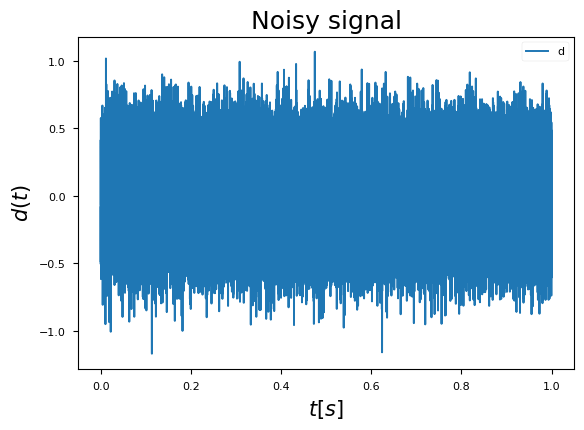

In [6]:
plot_data(filename, "Noisy signal")

* Enumerate through different parameter sets and plot them

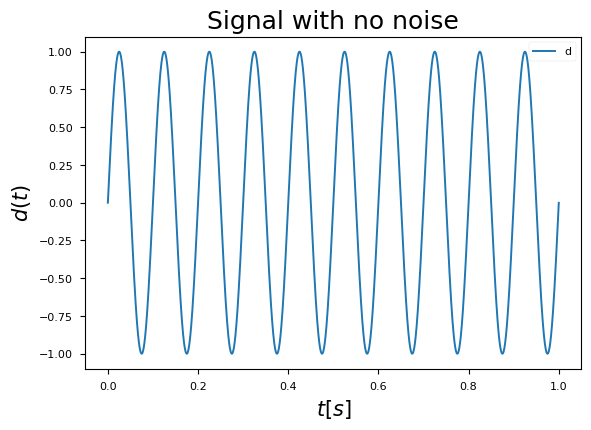

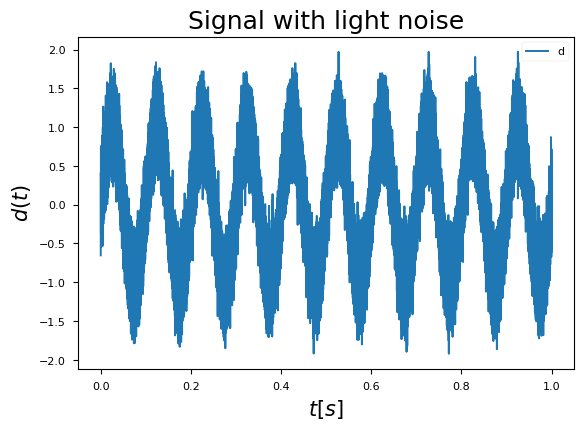

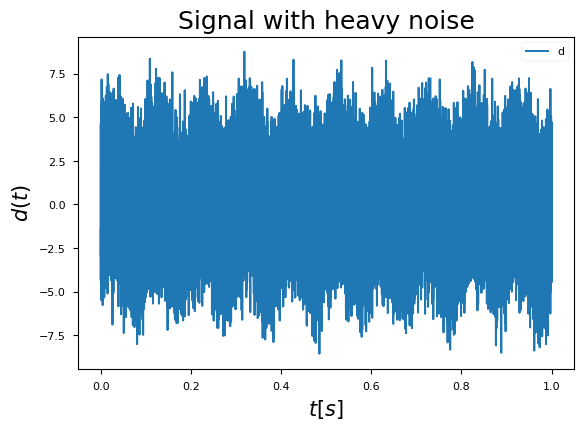

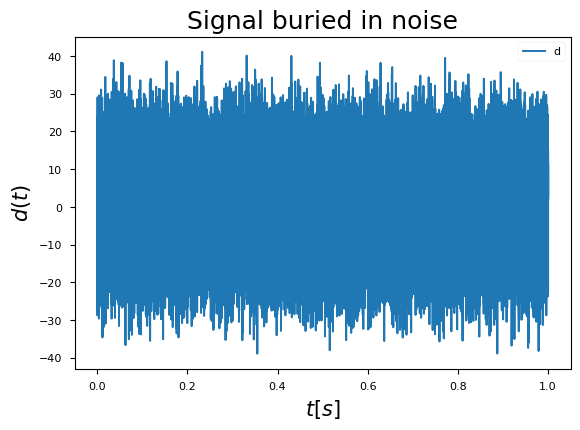

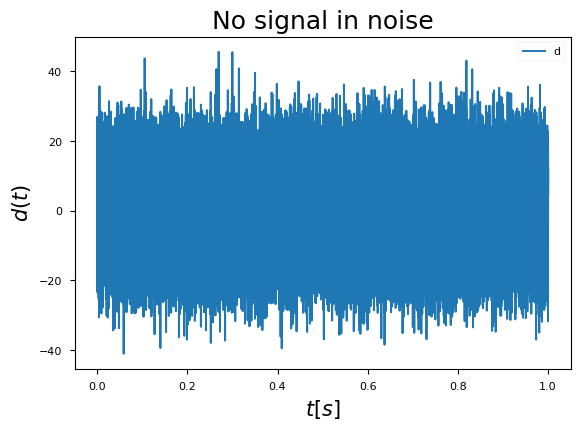

In [7]:
# Default parameters:
#    sigma=0.25
#    delta_T=1/N 
#    N=100000
#    f=0 
#    phi=0
#    A=0
#    r=0 - no random signal generation

test_set = {
    1: {
        'sigma': 0.0,
        'A': 1,
        'f': 10,
        'filename': "data_01.csv",
        'title': "Signal with no noise",
    },
    2: {
        'sigma': 0.25,
        'A': 1,
        'f': 10,
        'filename': "data_02.csv",
        'title': "Signal with light noise",
    },
    3: {
        'sigma': 2,
        'A': 1,
        'f': 10,
        'filename': "data_03.csv",
        'title': "Signal with heavy noise",
    },
    4: {
        'sigma': 10,
        'A': 1,
        'f': 10,
        'filename': "data_04.csv",
        'title': "Signal buried in noise",
    },
    5 : {
        'sigma': 10,
        'A': 0,
        'f': 10,
        'filename': "data_05.csv",
        'title': "No signal in noise",
    }
}

for key, value in test_set.items():
    generate_source(value.get('filename'), sigma=value.get('sigma'), A=value.get('A'), f=value.get('f'))
    plot_data(value.get('filename'), title=value.get('title'))

__Task 2__: Learn to use prober, our small black box program computing a scalar result based upon input time series and parameter point $(f,\phi)$. For more information use `./prober --help`

__Solution__: Write a function that calls the `prober`executable with given parameters. Try it on previous data.


In [27]:
def prober(inputFile, f=0, outputFile=None, phi=0, templateFile=None, mod=1):
    """
    Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
      -i, --input=<file>        input file
      -o, --output=<file>       output file
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -h, --help                print this help and exit
      -t, --templatebank=<file> template bank file
      -m, --method=<int>        select method to analyze signal 1, 2 or 3
    """
    
    if outputFile == None:
        outputFile = "results_" + str(uuid.uuid4()) + ".csv"
    
    exe_path = os.path.join(exe_dir, 'prober')
    
    """
    prober -i data/data_01.csv -o data/results_01.csv -t template.txt -m 1
    """
    cmd_str = f"{base_cmd} {exe_path} -i {output_dir}/{inputFile} "\
        f"-o {output_dir}/{outputFile} -m {mod}"
    
    if templateFile:
        cmd_str += f" -t {output_dir}/{templateFile} "
    else:
        cmd_str += f" -f {f} -p {phi}"
    
    # Optionally print the command line and test it outside the notebook
    # print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print('The process has an output:', out.decode())
    if os.path.isfile(outputFile):
        print(f"Output generated in file {outputFile}")

    return os.path.join(data_dir, outputFile)
    
    

In [28]:
prober("data_01.csv", f=10, mod=1)

The process has an output: 10 0 0.5



'../../Codes/data/results_a0f46c3f-4778-4ba4-9ecb-d149b1c3f59f.csv'

__Task 3__ Learn how prober results change, varying the parameters of an injected signal while probing the same parameter point.

In [10]:
generate_source("data_08.csv", f=10, phi=np.pi/2, sigma=0.1, A=2)

for i in range(1,9):
    prober(f"data_0{i}.csv", f=10, mod=1)

The process has an output: 10 0 0.5

The process has an output: 10 0 0.500409

The process has an output: 10 0 0.508913

The process has an output: 10 0 0.500382

The process has an output: 10 0 0.00823604

The process has an output: 10 0 1.7555e-08

The process has an output: 10 0 5.66244e-08

The process has an output: 10 0 -0.000107081



In [11]:
for i in range(1,8):
    prober(f"data_0{i}.csv", f=10, mod=2)

The process has an output: 10 0 3.35315e-13

The process has an output: 10 0 0.0626604

The process has an output: 10 0 3.97876

The process has an output: 10 0 99.8107

The process has an output: 10 0 100.401

The process has an output: 10 0 1

The process has an output: 10 0 1.5



In [12]:
freq = 10
phase = 0
# Apply prober to signal, changing the various options. 
resultf    = "prober_results.dat"
tbank      =  "tb.dat"
# Make a "template-bank" with a single template. 
with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
     tbfile.write(f"{freq} {phase}\n")
        

prober("data_01.csv", freq, resultf, mod=3)

data = np.loadtxt(os.path.join(data_dir,resultf))
print(np.max(data[:,2]))
print(np.sum(data[:,2]))

resultf = "results_03.dat"
prober("data_02.csv", 5.2, "results_03.dat", mod=1)

data = np.loadtxt(os.path.join(data_dir,resultf))
print(np.max(data[:,2]))
print(np.sum(data[:,2]))


# Note the different output format for methods:
# S1 outputs template_freq template_phase result (larger for signal).
# S2 outputs template_freq template_phase result (smaller for signal).
# S3 outputs freq ? result (larger for correct signal frequency), 
# with all freqs in rows.
# Prober returns numbers to stdout for S_1, S_2 if given single parameter point. 
# Always returns output file for S_3 or if given template bank?

2500000000.0
2500000000.0000076
The process has an output: 5.2 0 -0.0208629

2497350000.0
2810207927.086402


In [13]:
n = 300
f_list = np.linspace(0.01,100.0,n)

with open("data.txt" ,'w') as file:
    for f in f_list:
        file.write("{0} {1}\n".format(f,0))

__Solution__ Write a function that takes a number $(1, 2, 3)$ for the different sums $(S_1, S_2, S_3)$ and plots results for a frequency domain $(0, f_{max})$ with a step size $df (f_{max}/N_{df})$ 

In [53]:
def plot_freq_sol(datafile, N_df=300, f_max=100, mod=1, ph=0, title=None):
    # Make a frequency space from 0.01 to f_max with N_df steps
    f_list = np.linspace(0.01, f_max, N_df) 

    tbank = "tb_test.tb" # can parametrise this later
    
    # Generate template bank with this frequency space
    # You can also add phase space if feeling like doing a 3D plot
    with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        for i in range(N_df):
            tbfile.write("{0} {1}\n".format(f_list[i],ph))

    results_file = prober(datafile, templateFile=tbank, mod=mod)
    """
    Note the different output format for methods:
        S1 outputs template_freq template_phase result (larger for signal).
        S2 outputs template_freq template_phase result (smaller for signal).
        S3 outputs freq ? result (larger for correct signal frequency),
        with all freqs in rows.
    
    Result files per template bank: 
    
    f phi  S1      S2     S3
    10 0   value   value [N values] - getmax
    11 0   value   value [N values] 
    12 0   value   value [N values] 
    13 0   value   value [N values] 
    14 0   value   value [N values] 
    """    

    results = np.loadtxt(results_file)

    # Plotting
    plt.figure(figsize=(15,4))
    if not title:
        title = "$S_{mod}$ vs frequency"
        
    plt.title(title, fontsize=18)

    plt.plot(results[:,0],results[:,2])
    
    plt.xlim([0.01,f_max])
    plt.xscale('log')
    plt.xlabel("$f [Hz]$", fontsize=15)
    plt.ylabel("$S_{mod}(f)$", fontsize=15)
    
    plt.show()
    plt.close()

    # S_2 searching for a minimum:
    if mod == 2:
        best = np.where(results[:,2] == np.min(results[:,2]))
    else:
        best = np.where(results[:,2] == np.max(results[:,2]))
    
    print("Frequency  f = {0:.3f}Hz".format(freq))
    print("Best TS at f = {0:.3f}Hz".format(results[:,0][best][0]))

    # Different output format for S_3:
    if mod == 3:
        TS = np.max(results[:,2])
    elif mod== 1:
        TS = np.max(results[2])
    elif mod ==2:
        TS = np.min(results[2])

    print("TS at right f = {0:.3f} ({0:.8f})".format(TS))
    print("Best TS       = {0:.3f} ({0:.8f})".format(results[:,2][best][0]))

    return results[:,0][best][0]

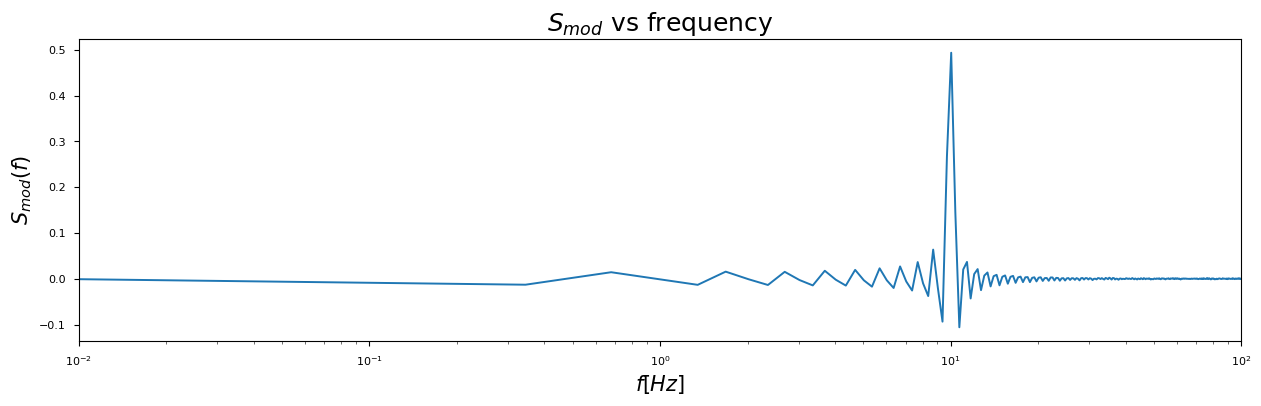

Frequency  f = 10.000Hz
Best TS at f = 10.042Hz
TS at right f = 0.679 (0.67882900)
Best TS       = 0.494 (0.49350200)


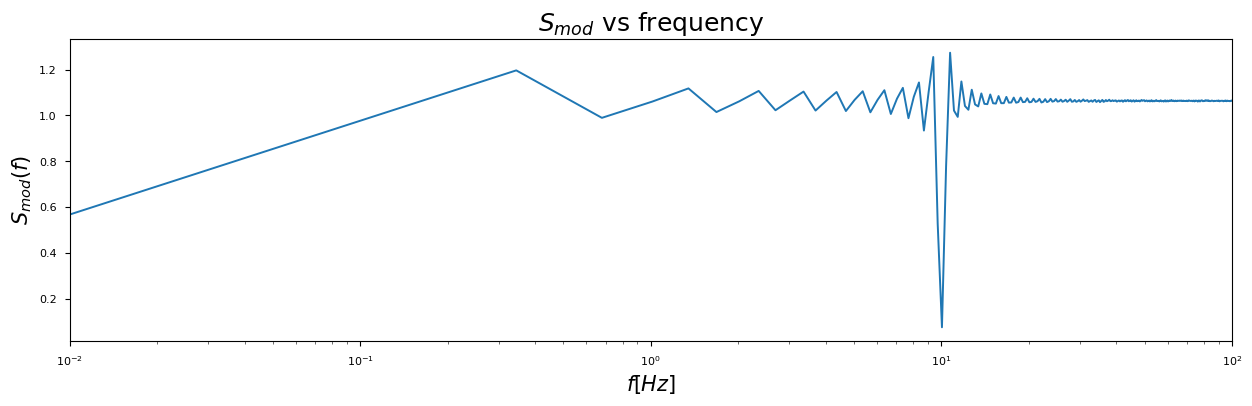

Frequency  f = 10.000Hz
Best TS at f = 10.042Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 0.074 (0.07446550)


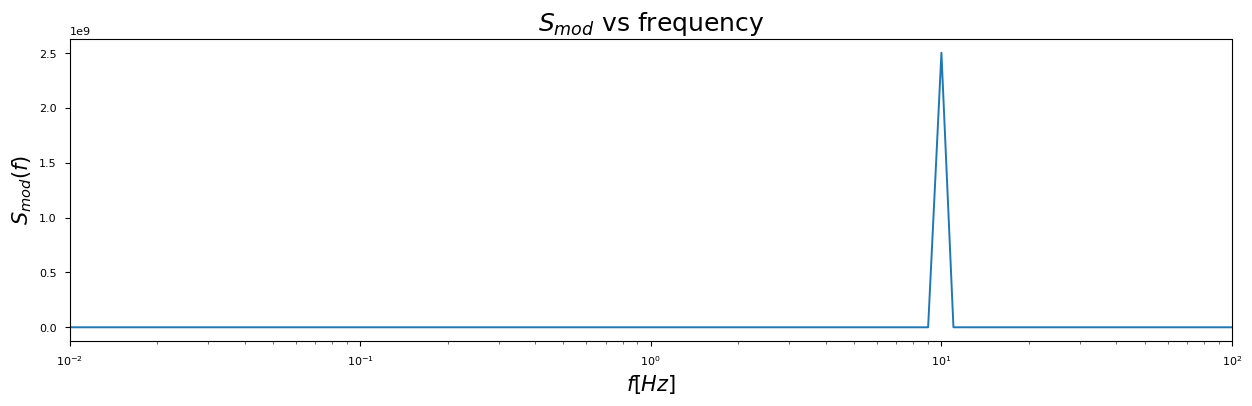

Frequency  f = 10.000Hz
Best TS at f = 10.000Hz
TS at right f = 2504110000.000 (2504110000.00000000)
Best TS       = 2504110000.000 (2504110000.00000000)


In [39]:
plot_freq_sol("data_02.csv", mod=1)
plot_freq_sol("data_02.csv", mod=2)
plot_freq_sol("data_02.csv", mod=3)

## Aliasing

> Side note on the importance of choosing the correct step size

In signal processing, __aliasing__ is an effect that causes different signals to become indistinguishable (or aliases of one another) when sampled. It also refers to the distortion or artifact that results when the signal reconstructed from samples is different from the original continuous signal.



0.1 0.05 0.025


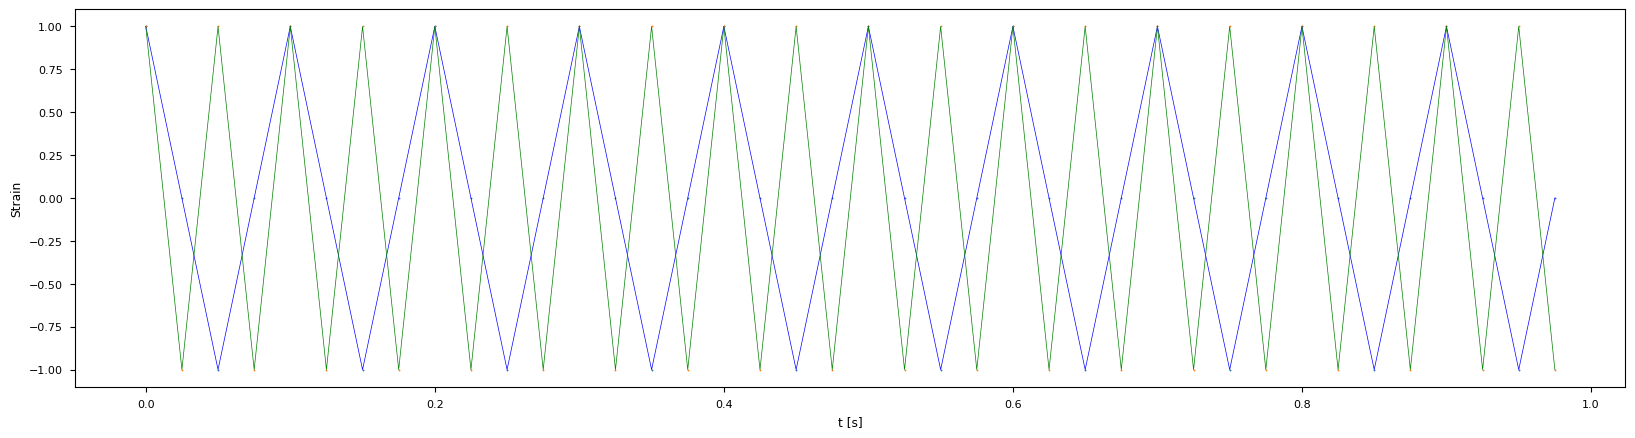

In [40]:
freq= 10
N=40 
print(1/freq, 0.5/freq, 1/N)
generate_source("data_06.csv", N=N, f=freq, phi=np.pi/2, sigma=0.0, A=1)
file = np.loadtxt(os.path.join(data_dir, "data_06.csv"))

generate_source("data_07.csv", N=N, f=2*freq, phi=np.pi/2, sigma=0.0, A=1)
file2 = np.loadtxt(os.path.join(data_dir, "data_07.csv"))

plt.figure(figsize=(20,5))
plt.scatter(file[:,0],file[:,1], s=1)
plt.plot(file[:,0],file[:,1], linewidth=0.5, color="blue")
plt.scatter(file2[:,0],file2[:,1], s=1)
plt.plot(file2[:,0],file2[:,1], linewidth=0.5, color="green")
#plt.xlim(0.,0.1)
plt.xlabel("t [s]")
plt.ylabel("Strain")
plt.show()
plt.close()
# Aliasing. For signal of frequency f, a sample-rate (strictly) larger 
# than 2f is sufficient. 



__Task 4__ Plot/document result findings: how large may the mismatch between injection and probed set of parameters become? What happens with weak signals (small amplitude)?

__Solution:__ Use previous function to plot the three methods for a signal in noise. Slowly decrease the signal amplitude and see what happens. For fun also change the signal frequency.


Trail with A = 10


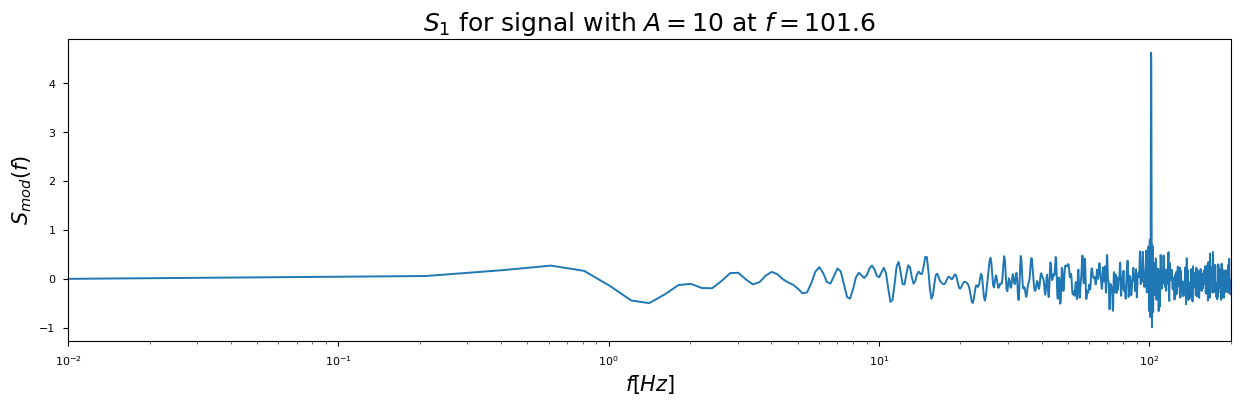

Frequency  f = 101.600Hz
Best TS at f = 101.506Hz
TS at right f = 0.410 (0.41038000)
Best TS       = 4.625 (4.62515000)


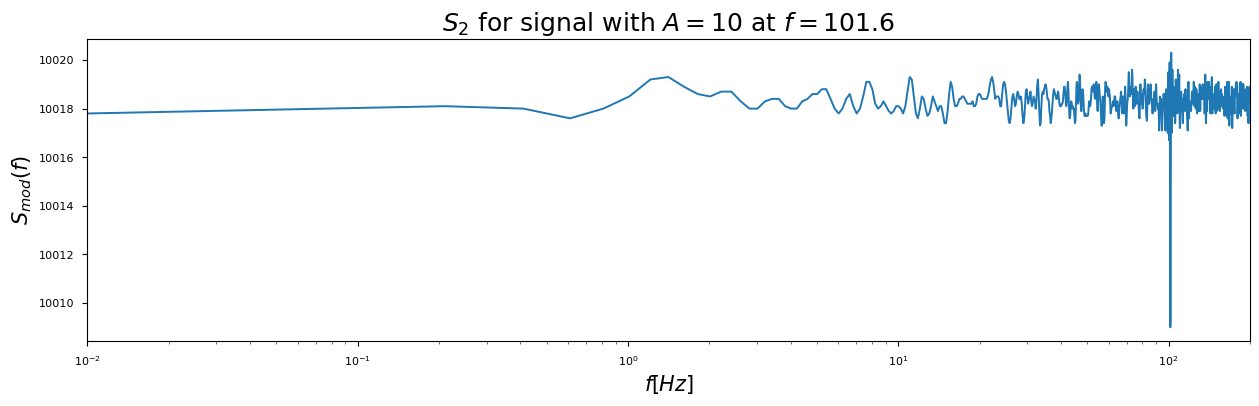

Frequency  f = 101.600Hz
Best TS at f = 101.506Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 10009.000 (10009.00000000)


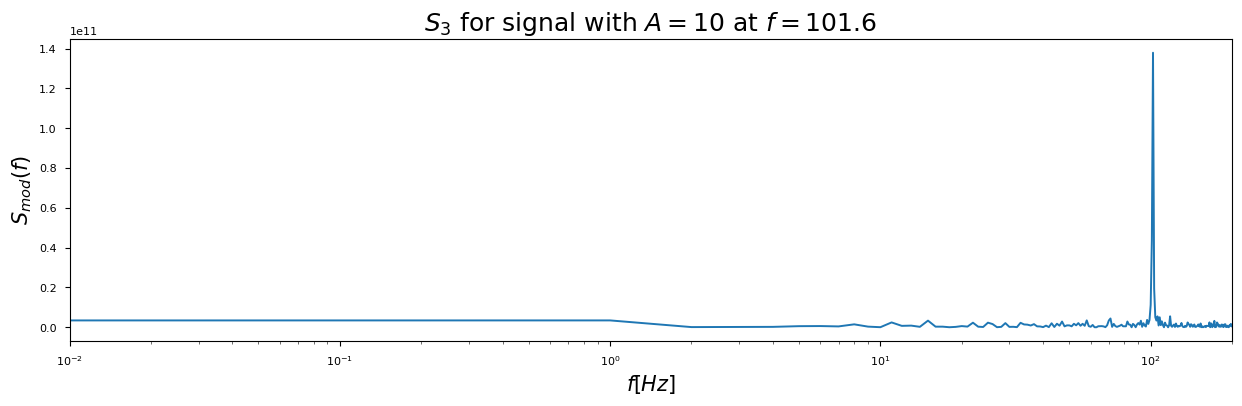

Frequency  f = 101.600Hz
Best TS at f = 102.000Hz
TS at right f = 137965000000.000 (137965000000.00000000)
Best TS       = 137965000000.000 (137965000000.00000000)

Trail with A = 5


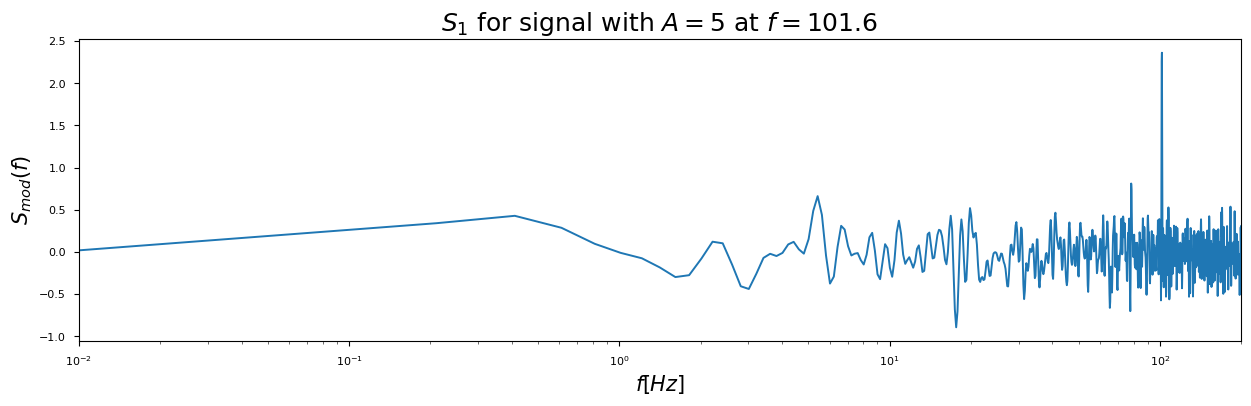

Frequency  f = 101.600Hz
Best TS at f = 101.707Hz
TS at right f = 0.428 (0.42849400)
Best TS       = 2.363 (2.36267000)


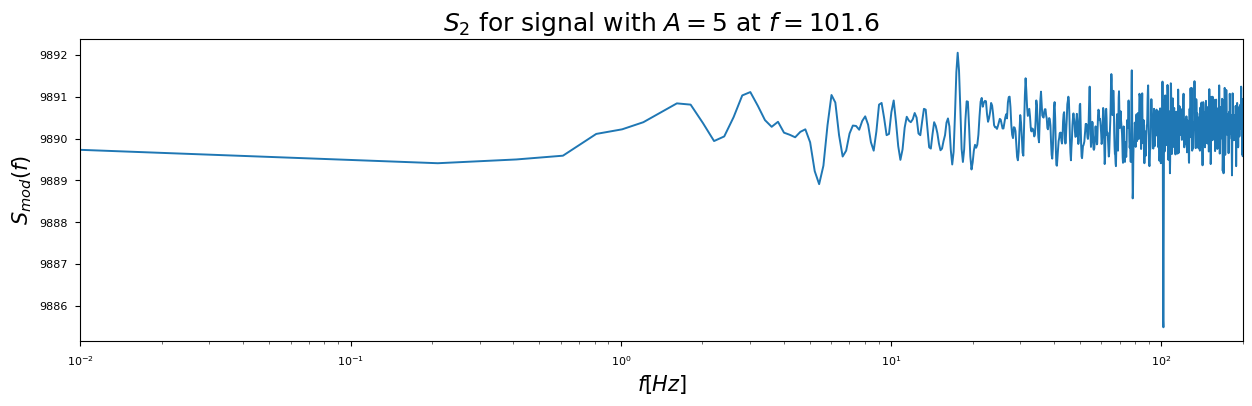

Frequency  f = 101.600Hz
Best TS at f = 101.707Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 9885.490 (9885.49000000)


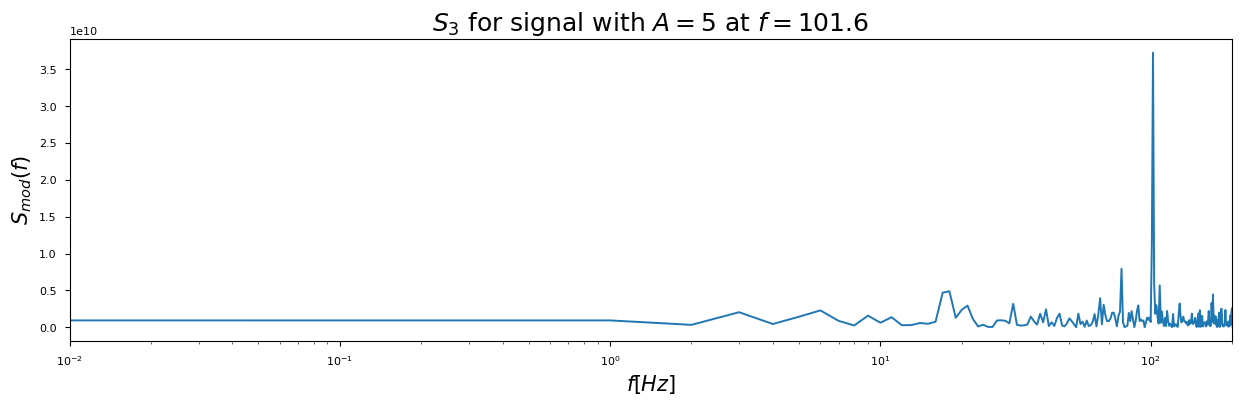

Frequency  f = 101.600Hz
Best TS at f = 102.000Hz
TS at right f = 37268600000.000 (37268600000.00000000)
Best TS       = 37268600000.000 (37268600000.00000000)

Trail with A = 1


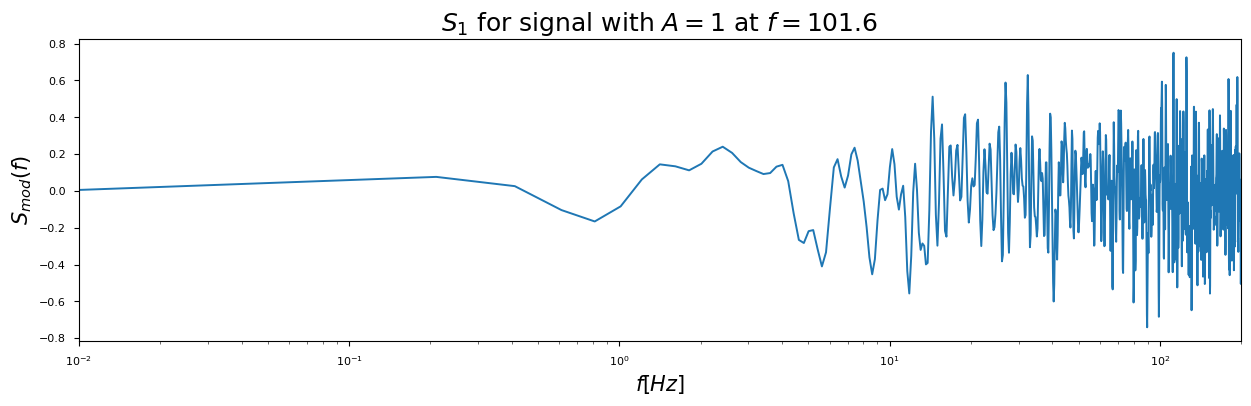

Frequency  f = 101.600Hz
Best TS at f = 112.317Hz
TS at right f = 0.410 (0.41038000)
Best TS       = 0.751 (0.75060700)


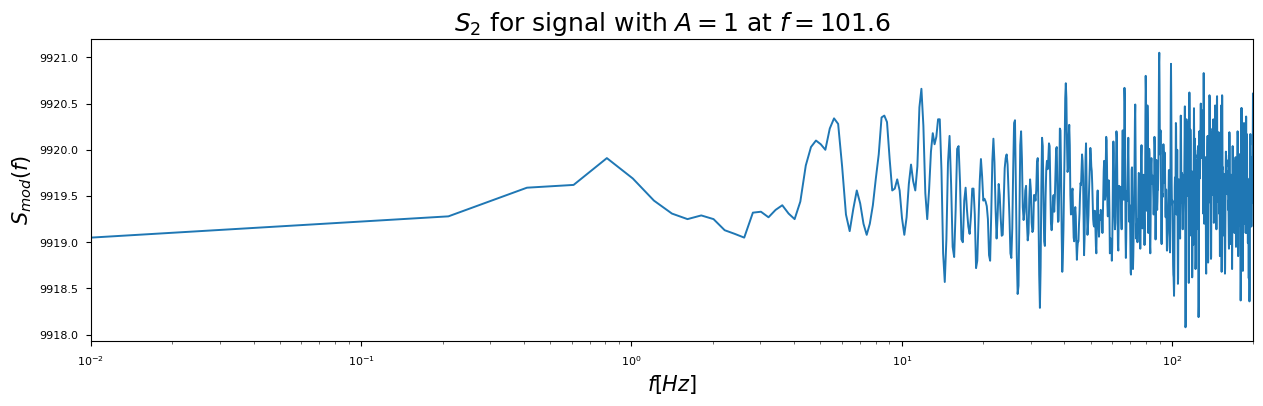

Frequency  f = 101.600Hz
Best TS at f = 112.117Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 9918.080 (9918.08000000)


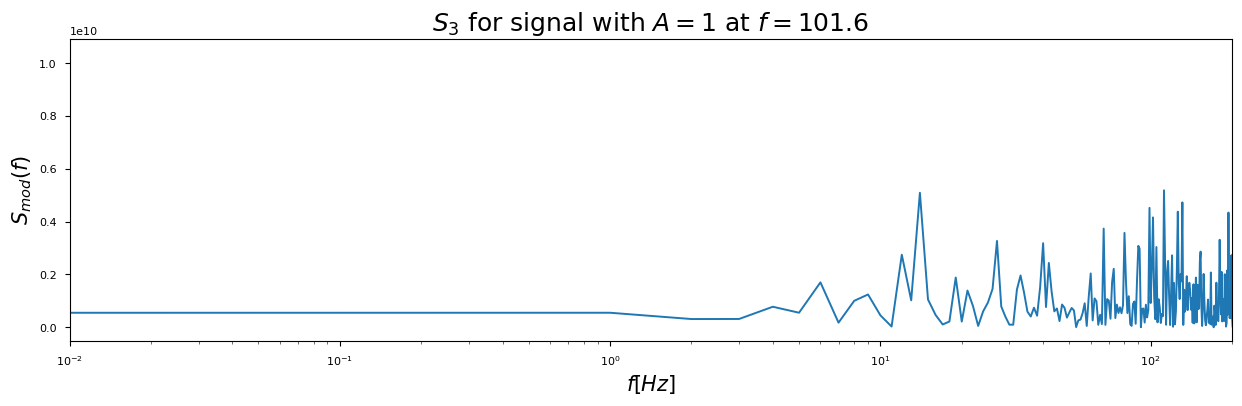

Frequency  f = 101.600Hz
Best TS at f = 1516.000Hz
TS at right f = 10396200000.000 (10396200000.00000000)
Best TS       = 10396200000.000 (10396200000.00000000)

Trail with A = 0.5


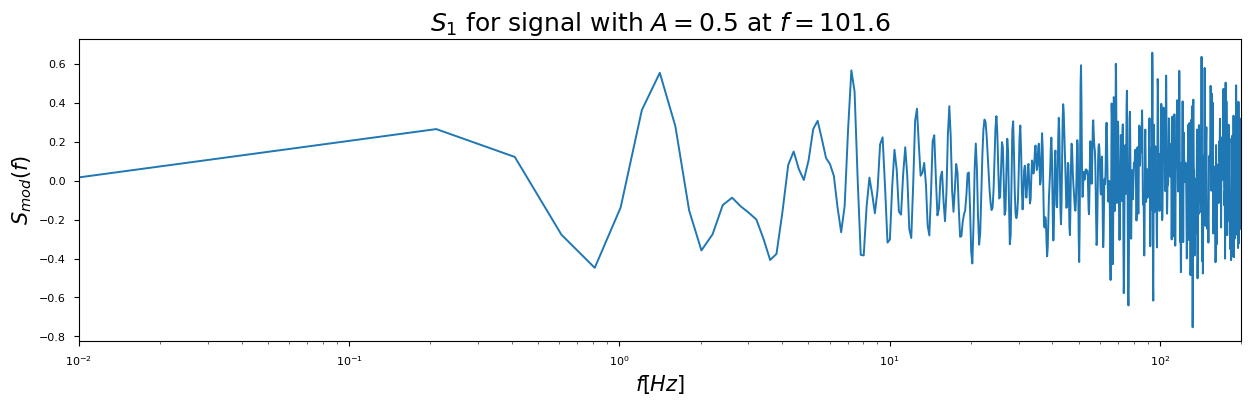

Frequency  f = 101.600Hz
Best TS at f = 93.699Hz
TS at right f = 0.410 (0.41038000)
Best TS       = 0.659 (0.65851500)


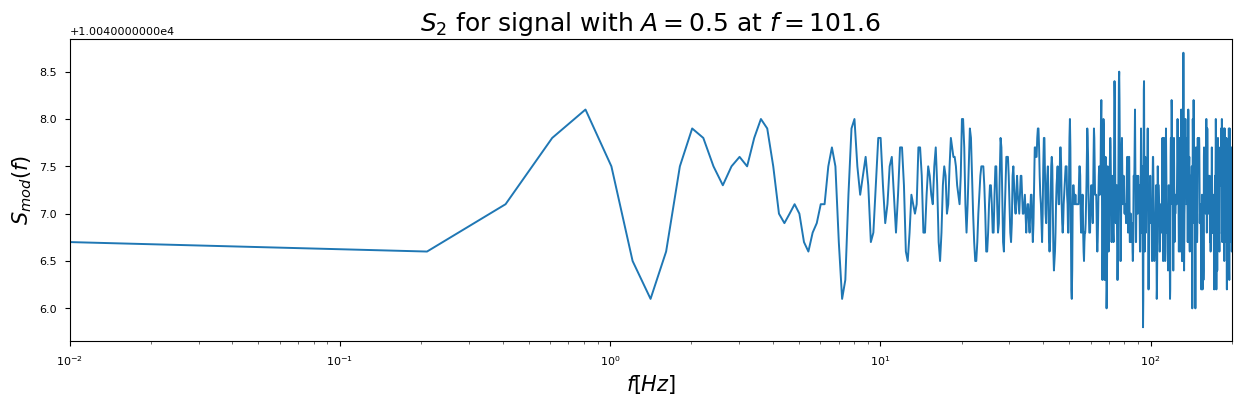

Frequency  f = 101.600Hz
Best TS at f = 93.699Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 10045.800 (10045.80000000)


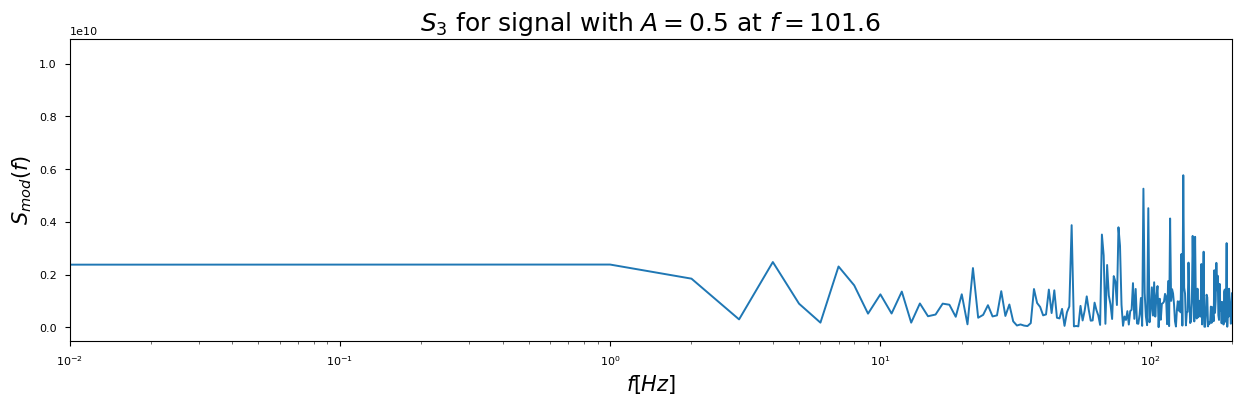

Frequency  f = 101.600Hz
Best TS at f = 40254.000Hz
TS at right f = 10420200000.000 (10420200000.00000000)
Best TS       = 10420200000.000 (10420200000.00000000)


In [24]:
"""
sigma      = 100.0
N          = 100000
dt         = 1.0/N
amp        = 10 to 1 
t          = 1 (s)
N_df       = 300
freq       = 14.3
f_max      = 100   
phase      = 0.
"""
sig, N_df, freq, f_max = 100, 1000, 101.6, 200

for amp in [10, 5, 1, 0.5]:
    input_file = f"data_task4_{freq}_a{amp}.csv"
    generate_source(input_file, sigma=sig, f=freq, A=amp) 
    print(f"\nTrail with A = {amp}")
    plot_freq_sol(input_file, N_df, f_max, mod=1, title=f"$S_1$ for signal with $A = {amp}$ at $f={freq}$")

    plot_freq_sol(input_file, N_df, f_max, mod=2, title=f"$S_2$ for signal with $A = {amp}$ at $f={freq}$")

    plot_freq_sol(input_file, N_df, f_max, mod=3, title=f"$S_3$ for signal with $A = {amp}$ at $f={freq}$")
    


We can define a notion of __mismatch__, or squared length of a parameter offset $\delta\lambda = \lambda - \lambda_s$ 

$m = \delta\lambda^2$


Trail with A = 10


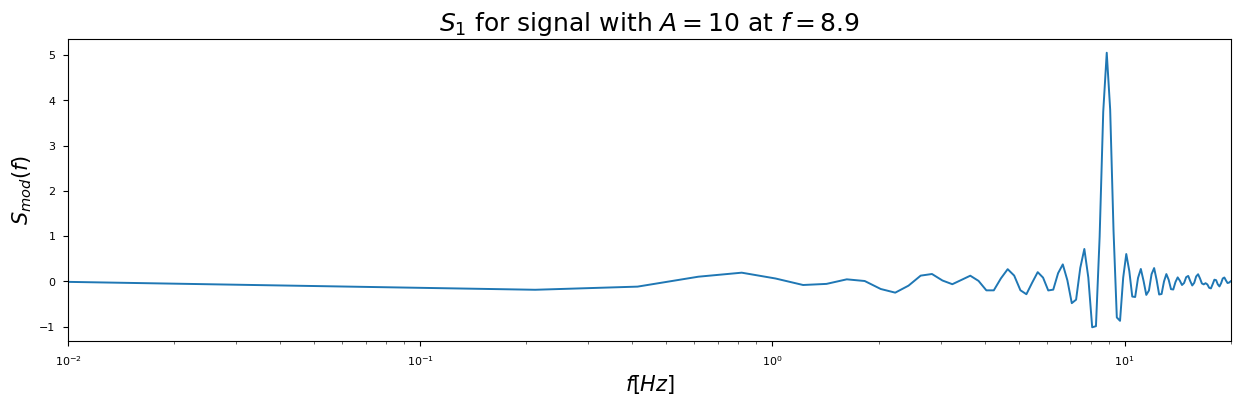

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.414 (0.41383800)
Best TS       = 5.051 (5.05134000)
Mismatch: 3.091360000000998e-05


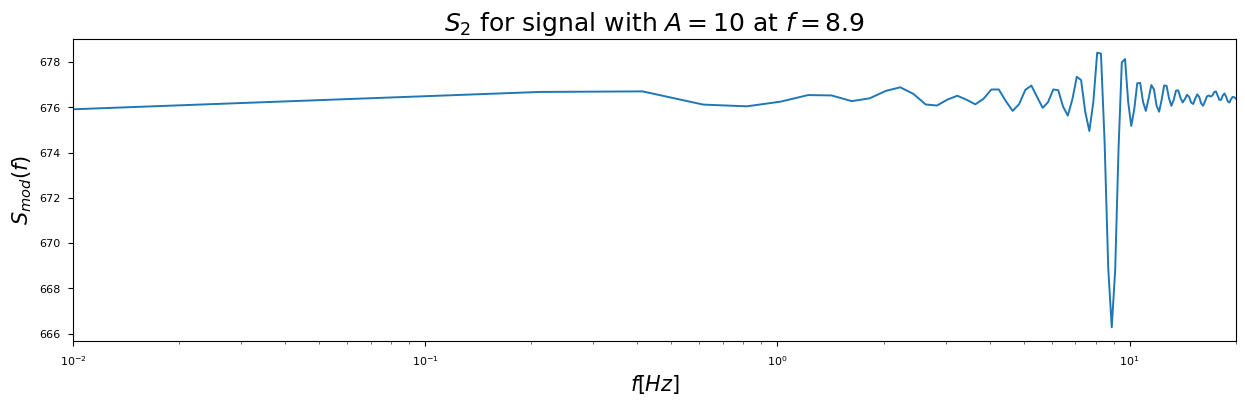

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 666.282 (666.28200000)
Mismatch: 3.091360000000998e-05


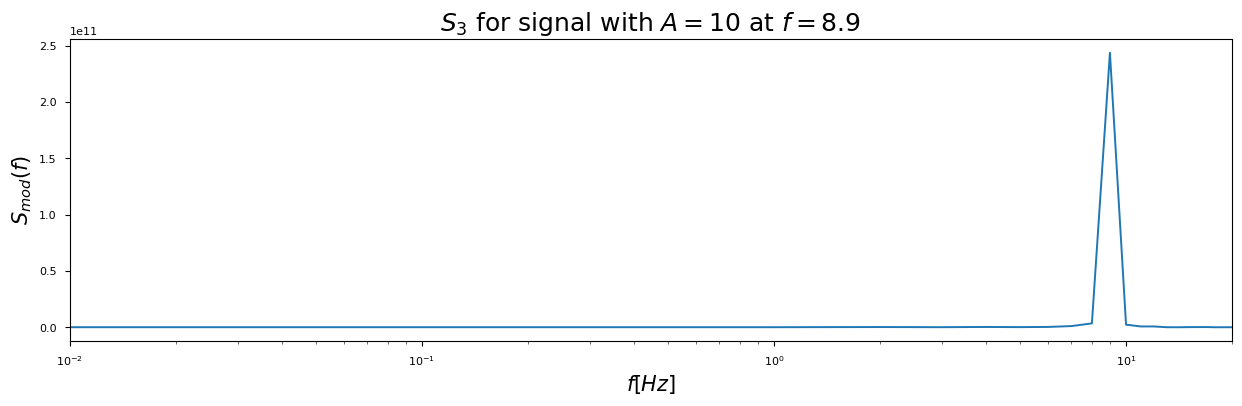

Frequency  f = 8.900Hz
Best TS at f = 9.000Hz
TS at right f = 243736000000.000 (243736000000.00000000)
Best TS       = 243736000000.000 (243736000000.00000000)
Mismatch: 0.009999999999999929

Trail with A = 5


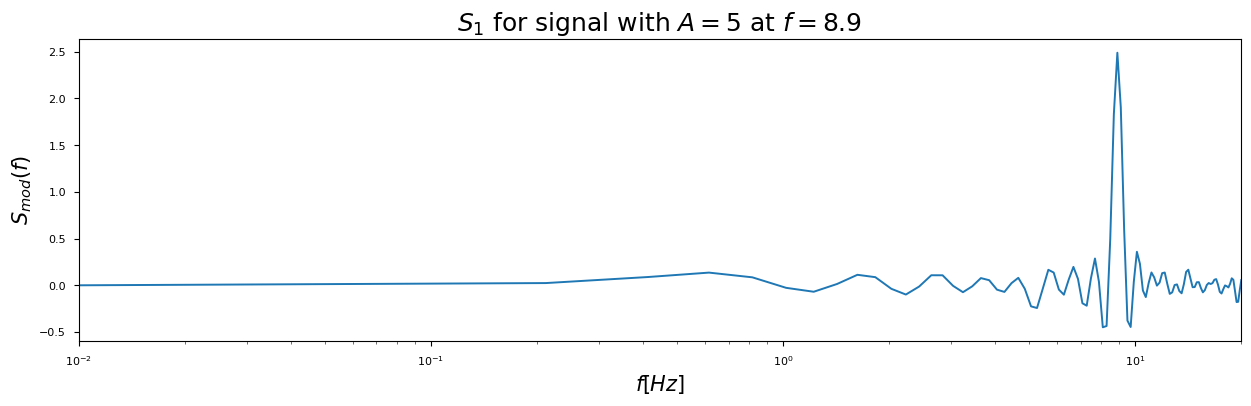

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.414 (0.41383800)
Best TS       = 2.489 (2.48929000)
Mismatch: 3.091360000000998e-05


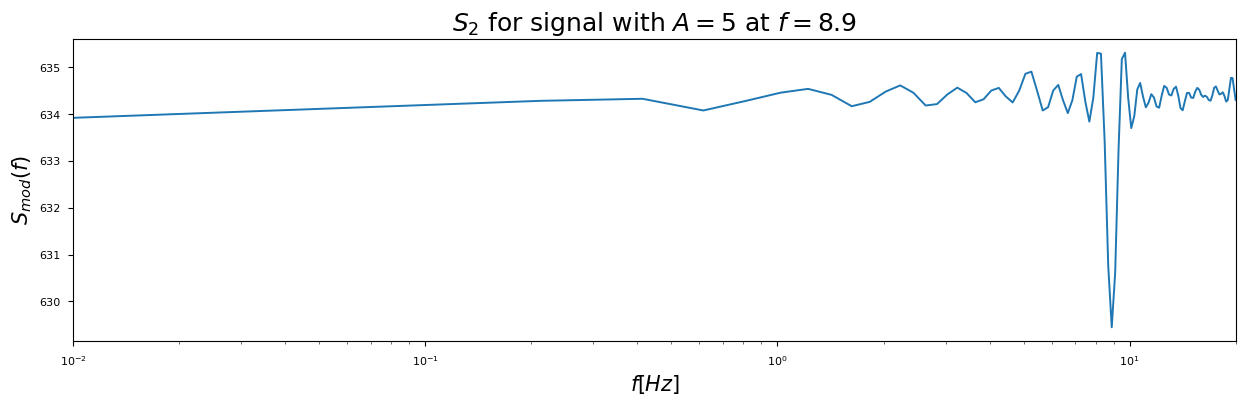

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 629.448 (629.44800000)
Mismatch: 3.091360000000998e-05


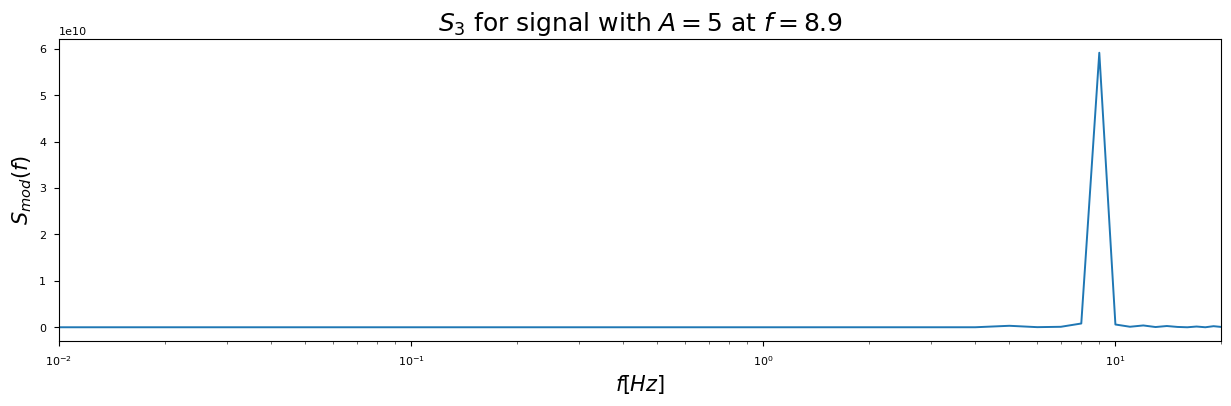

Frequency  f = 8.900Hz
Best TS at f = 9.000Hz
TS at right f = 59142400000.000 (59142400000.00000000)
Best TS       = 59142400000.000 (59142400000.00000000)
Mismatch: 0.009999999999999929

Trail with A = 1


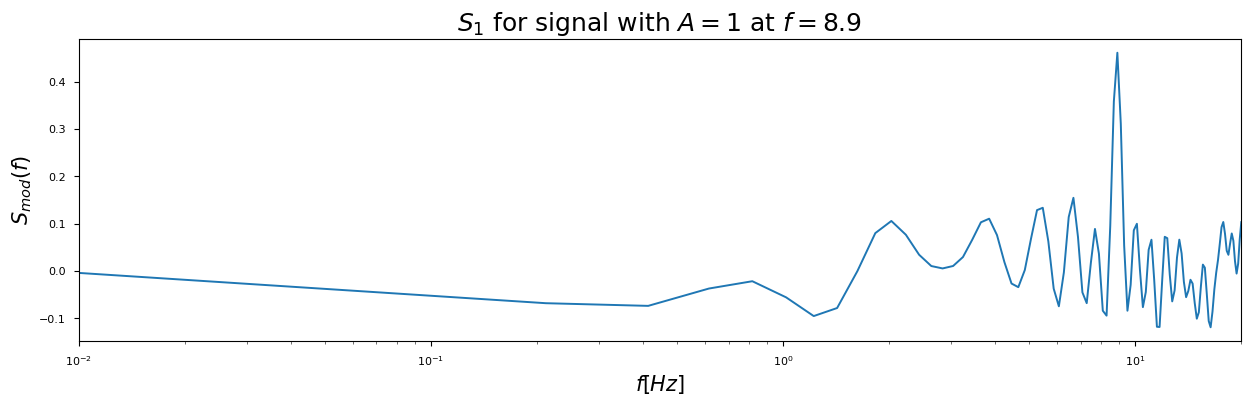

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.414 (0.41383800)
Best TS       = 0.461 (0.46127600)
Mismatch: 3.091360000000998e-05


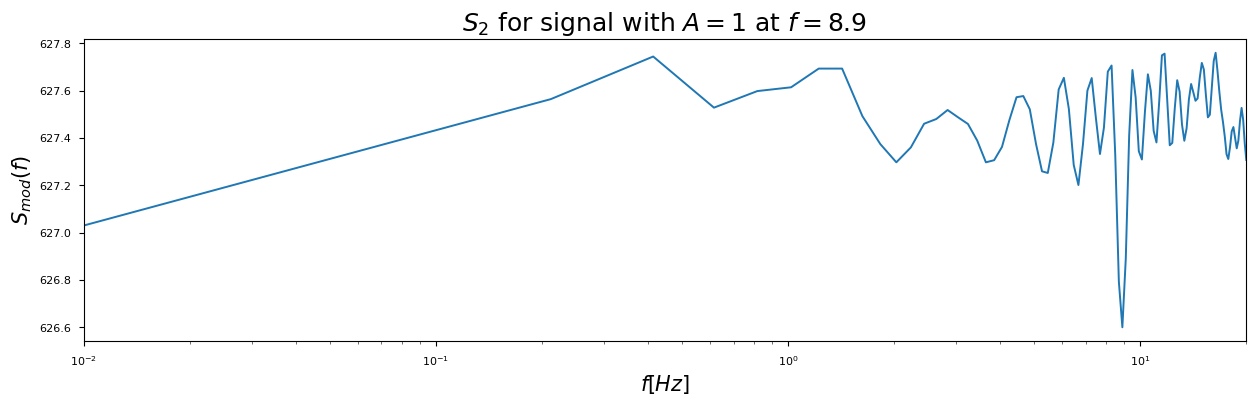

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 626.600 (626.60000000)
Mismatch: 3.091360000000998e-05


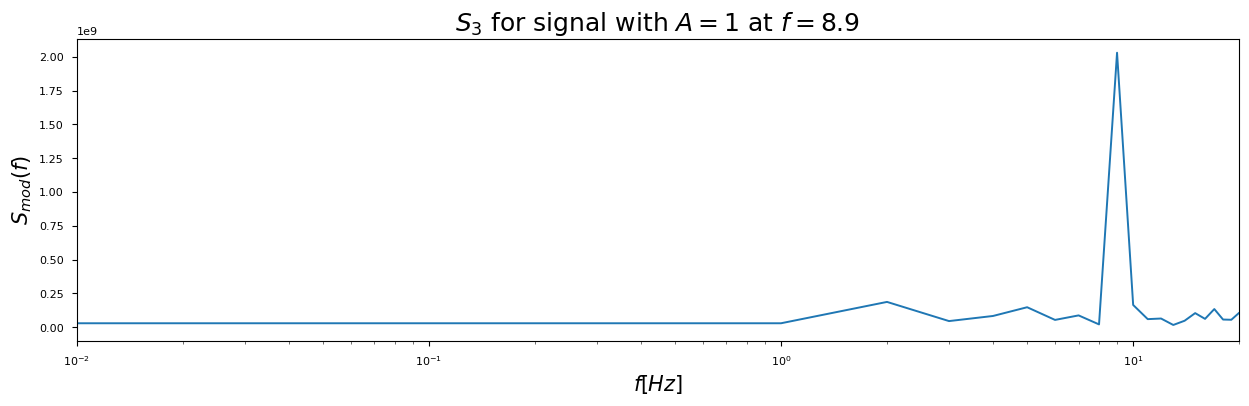

Frequency  f = 8.900Hz
Best TS at f = 9.000Hz
TS at right f = 2029710000.000 (2029710000.00000000)
Best TS       = 2029710000.000 (2029710000.00000000)
Mismatch: 0.009999999999999929

Trail with A = 0.5


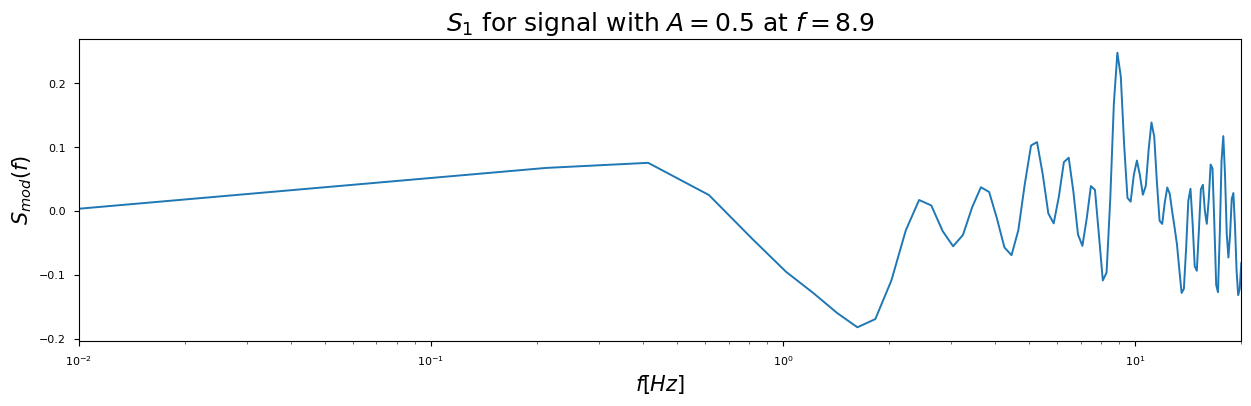

Frequency  f = 8.900Hz
Best TS at f = 8.894Hz
TS at right f = 0.414 (0.41383800)
Best TS       = 0.248 (0.24794500)
Mismatch: 3.091360000000998e-05


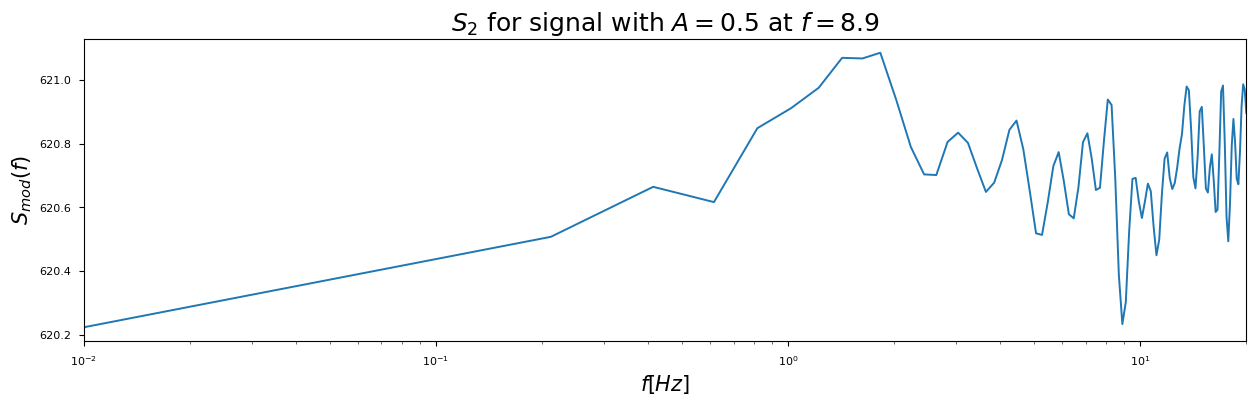

Frequency  f = 8.900Hz
Best TS at f = 0.010Hz
TS at right f = 0.000 (0.00000000)
Best TS       = 620.223 (620.22300000)
Mismatch: 79.03210000000001


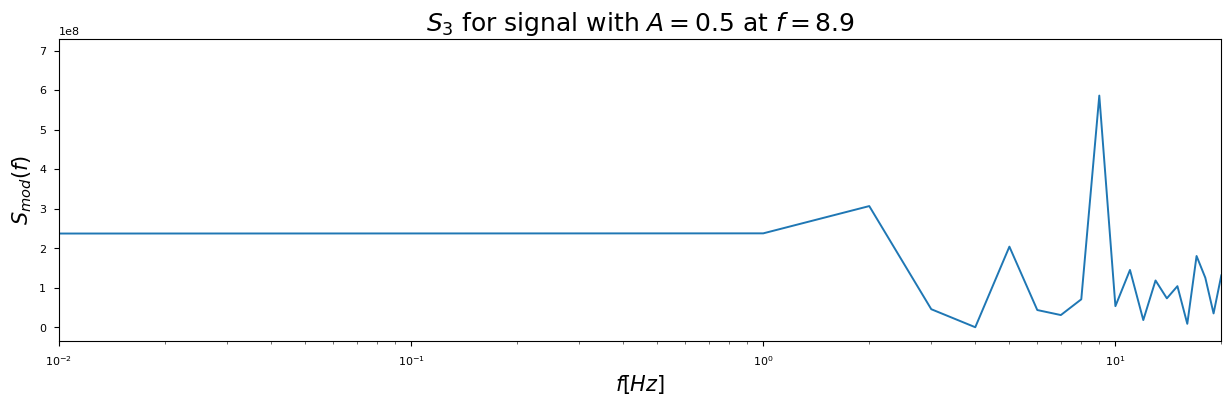

Frequency  f = 8.900Hz
Best TS at f = 48085.000Hz
TS at right f = 694582000.000 (694582000.00000000)
Best TS       = 694582000.000 (694582000.00000000)
Mismatch: 2311311391.21


In [26]:
sig, N_df, freq, f_max = 25, 100, 8.9, 20

for amp in [10, 5, 1, 0.5]:
    input_file = f"data_task4_{freq}_a{amp}.csv"
    generate_source(input_file, sigma=sig, f=freq, A=amp) 
    print(f"\nTrail with A = {amp}")
    freq_1 = plot_freq_sol(input_file, N_df, f_max, mod=1,
                  title=f"$S_1$ for signal with $A = {amp}$ at $f={freq}$")
    print(f"Mismatch: {(freq_1 -freq)**2}")
    freq_2 = plot_freq_sol(input_file, N_df, f_max, mod=2,
                  title=f"$S_2$ for signal with $A = {amp}$ at $f={freq}$")
    print(f"Mismatch: {(freq_2 -freq)**2}")
    freq_3 = plot_freq_sol(input_file, N_df, f_max, mod=3,
                  title=f"$S_3$ for signal with $A = {amp}$ at $f={freq}$")
    print(f"Mismatch: {(freq_3 -freq)**2}")

In [40]:
def plot_multiple(datafiles, N_df=300, f_max=100, f_min=0.01, mod=1, ph=0, title=None):
    # Make a frequency space from 0.01 to f_max with N_df steps
    f_list = np.linspace(f_min, f_max, N_df) 

    tbank = "tb_test.tb" # can parametrise this later
    
    # Generate template bank with this frequency space
    # You can also add phase space if feeling like doing a 3D plot
    with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        for i in range(N_df):
            tbfile.write("{0} {1}\n".format(f_list[i],ph))

    plt.figure(figsize=(15,4))
    if not title:
        title = f"$S_{mod}$ multiple files"
    plt.title(title, fontsize=18)
    plt.xlim([f_min,f_max])
    plt.xscale('log')
    plt.xlabel("$f [Hz]$", fontsize=15)
    plt.ylabel("$S_{mod}(f)$", fontsize=15)
    
    res = []
    for datafile in datafiles: 
        results_file = prober(datafile, templateFile=tbank, mod=mod)
        results = np.loadtxt(results_file)
        label = "A=" + datafile.strip('.csv').split('_a')[1]
        plt.plot(results[:,0],results[:,2], label=label)
        if mod == 2:
            best = np.where(results[:,2] == np.min(results[:,2]))
        else:
            best = np.where(results[:,2] == np.max(results[:,2]))
        res.append(results[:,0][best][0])
    
    plt.legend()
    plt.show()
    plt.close()

    return np.array(res)


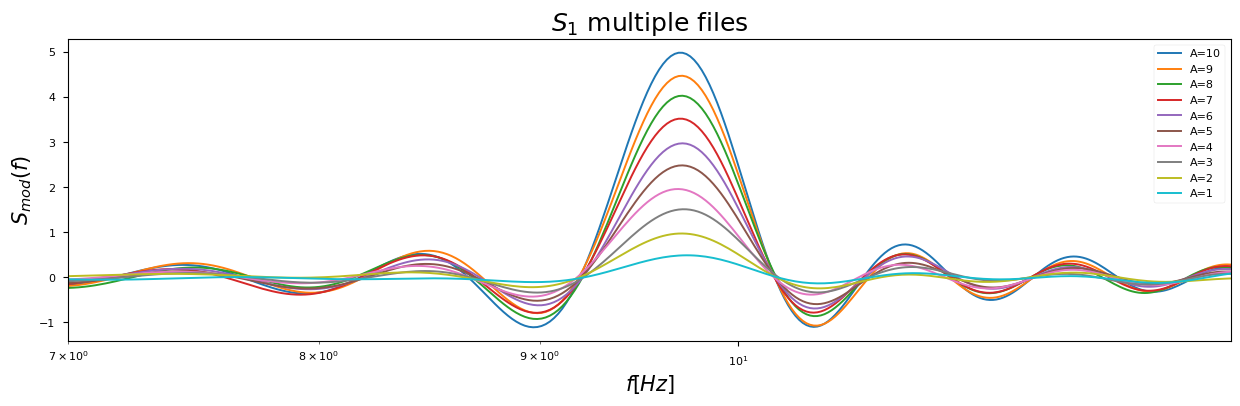

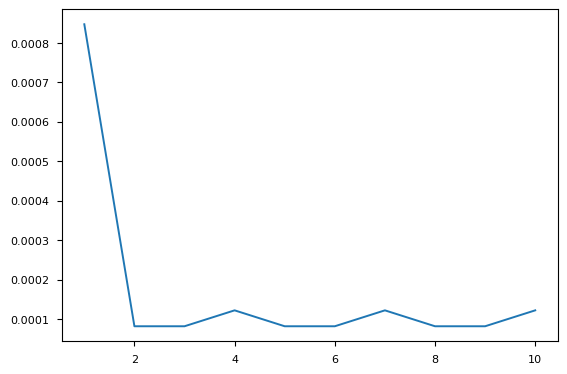

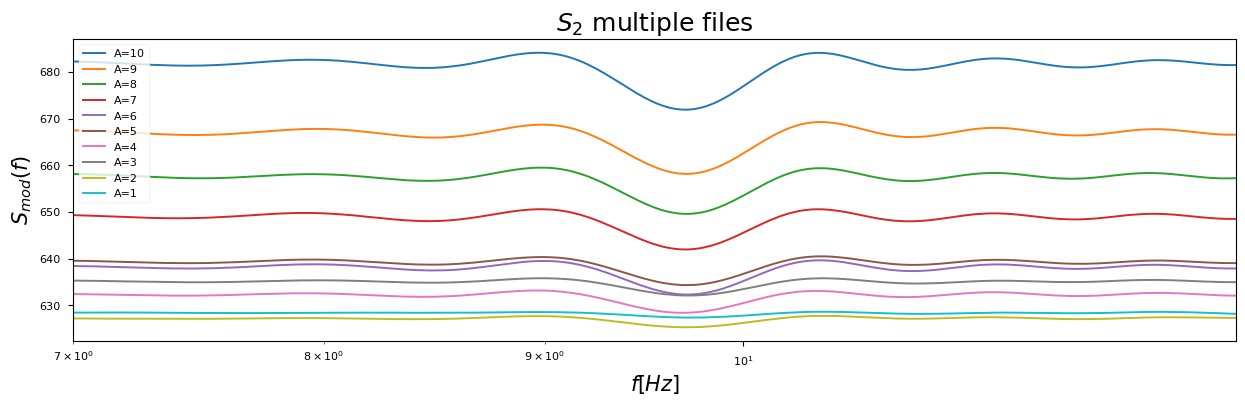

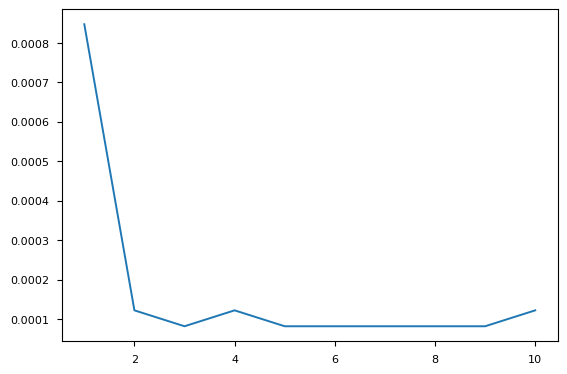

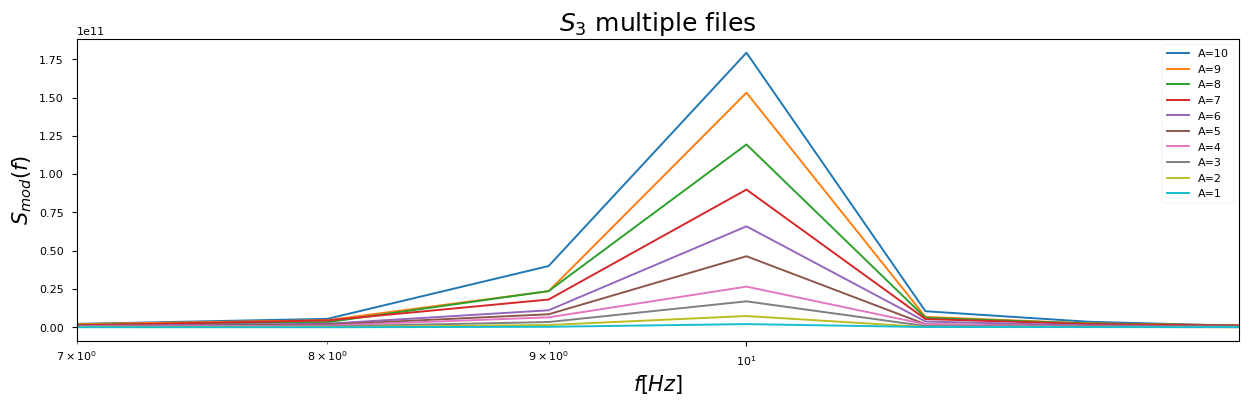

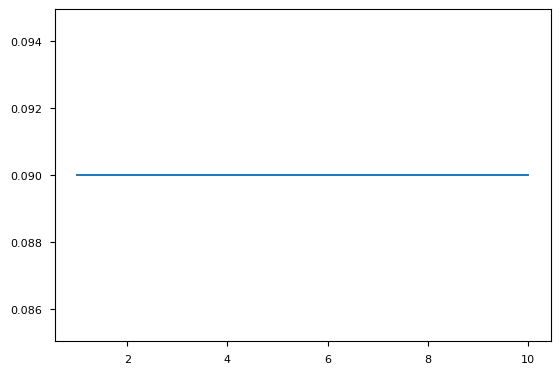

In [42]:
freq = 9.7
f_max = 13
f_min = 7

input_files = []
for amp in range(10, 0, -1):
    input_file = f"data_task5_{freq}_a{amp}.csv"
    input_files.append(input_file)
    generate_source(input_file, sigma=sig, f=freq, A=amp) 

res = plot_multiple(input_files, mod=1, f_max=f_max, f_min=f_min)
mismatch = (res-freq)**2
plt.plot(range(10, 0, -1), mismatch)
plt.show()
plt.close()
res = plot_multiple(input_files, mod=2, f_max=f_max, f_min=f_min)
mismatch = (res-freq)**2
plt.plot(range(10, 0, -1), mismatch)
plt.show()
plt.close()
res = plot_multiple(input_files, mod=3, f_max=f_max, f_min=f_min)
mismatch = (res-freq)**2
plt.plot(range(10, 0, -1), mismatch)
plt.show()
plt.close()

__Task 5__ Develop a strategy to find a signal using prober for a signal with unknown parameters $(A, f, \phi)$.

__Solution__ Modify template bank to search over $(f, \phi)$ grid. Return best result per method $(f_{best} , \phi_{best})$, also return value at that point. Try to correlate to amplitude. 


In [44]:
import math as m
def search_f_ph(datafile, freq=None, phase=None, N_df=100, f_min=0.01, f_max=20, mod=1, N_ph=50, title=None):
    # Make a frequency space from 0.01 to f_max with N_df steps
    freqs = np.linspace(f_min, f_max, N_df) 
    phases = np.linspace(0, 2*m.pi, N_ph)

    tbank = "tb_test_fphi.tb" # can parametrise this later
    
    # Generate template bank with this frequency space
    # You can also add phase space if feeling like doing a 3D plot
    with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        for f in freqs:
            for ph in phases:
                tbfile.write("{0} {1}\n".format(f,ph))

    results_file = prober(datafile, templateFile=tbank, mod=mod)
    results = np.loadtxt(results_file)
    
    # Plotting
    plt.figure(figsize=(15,4))
    if mod == 3:
        ### This is justa Fourier transform, template bank ignored 1/N frequencies tested
        best = np.where(results[:,2] == np.max(results[:,2]))
        plt.plot(results[:,0], results[:,2])
        plt.xscale('log')
        plt.xlabel("f [Hz]")
        plt.show()
        plt.close()
        
        print(results[:,0][best][0], 0, results[:,2][best][0])
        
        return (results[:,0][best][0], 0, results[:,2][best][0])
    
    levels = np.linspace(np.min(results[:,2]),np.max(results[:,2]),30)
    CS = plt.contourf(results[:,0].reshape(N_df,N_ph),results[:,1].reshape(N_df,N_ph),results[:,2].reshape(N_df,N_ph),levels)
    
    if (freq and phase):
        plt.scatter(freq,phase,marker="x", label="Injection point")
    
    # Plot best match
    if mod == 1 :
        # For S_1 get the maximum
        plt.scatter(results[np.argmax(results[:,2])][0], results[np.argmax(results[:,2])][1], marker="o", label="Loudest point")
        best_phi, best_f, best_val = results[np.argmax(results[:,2])]
    elif mod == 2: 
        # For S_2 get the minimum
        plt.scatter(results[np.argmin(results[:,2])][0], results[np.argmin(results[:,2])][1], marker="o", label="Loudest point")
        best_phi, best_f, best_val = results[np.argmin(results[:,2])]
        
    plt.title(f"Searching over frequency and phase - 2D search $S_{mod}$")
    plt.legend(loc='best')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Phase")
    plt.colorbar(CS, label="Prober output")
    plt.show()
    plt.close()
    
    ### Caluclate amplitude (look at data at peak)
    print(best_phi, best_f, best_val)
    
    return (best_phi, best_f, best_val)

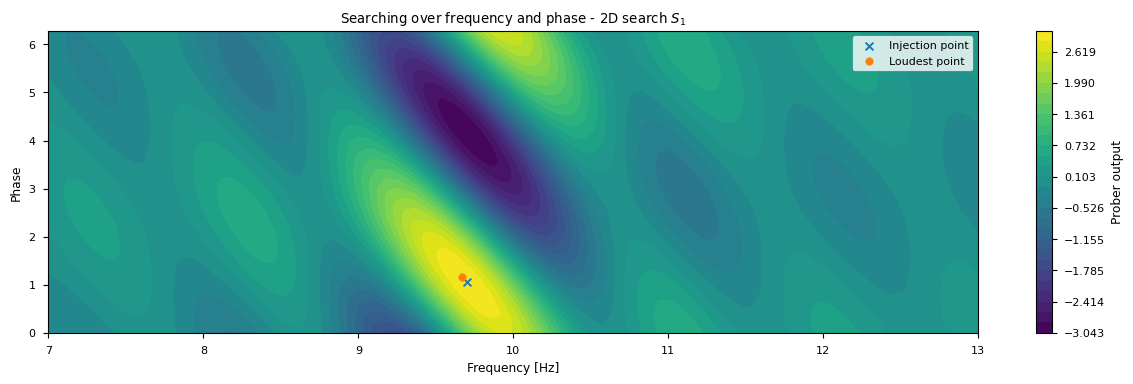

9.66667 1.15405 3.03805


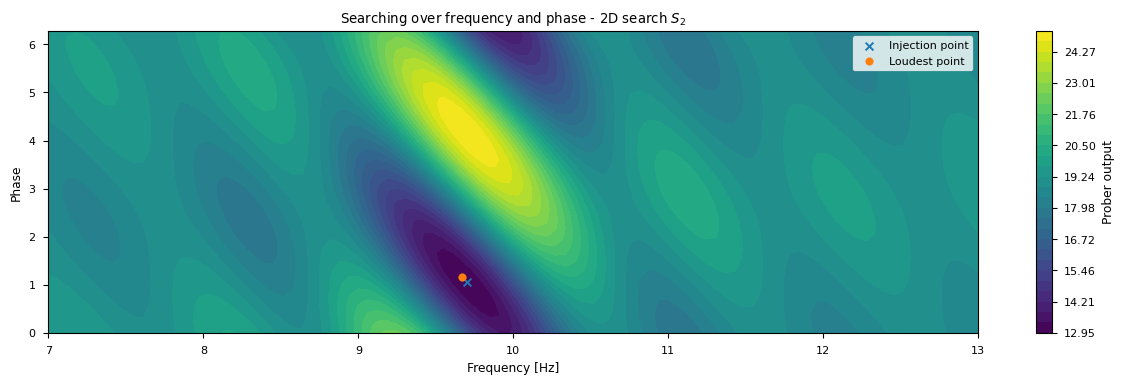

9.66667 1.15405 12.9479


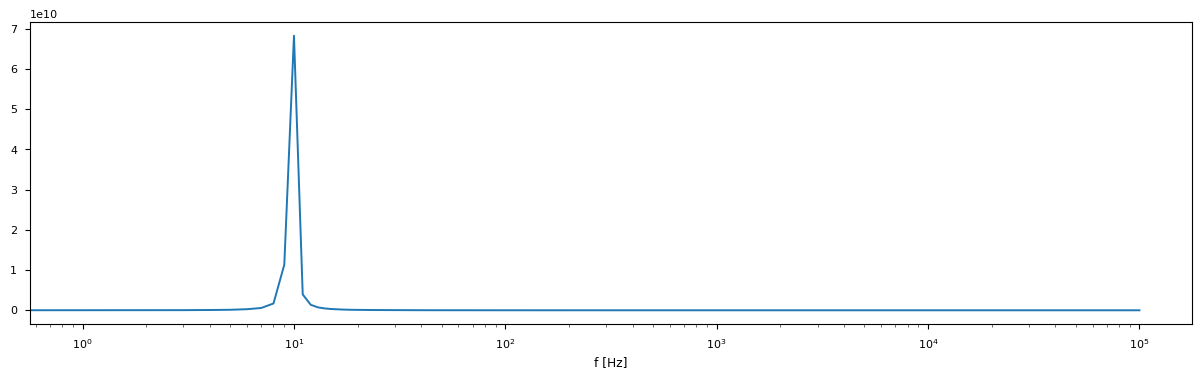

10.0 0 68288700000.0


(10.0, 0, 68288700000.0)

In [46]:
# Inject signal
freq = 9.7
f_max = 13
f_min = 7
amp = 6
sig = 0.5
phase = m.pi/3
N = 100000

input_file = f"data_task5_{int(freq*1000)}mHz_{amp}.csv"

generate_source(input_file, sigma=sig, f=freq, A=amp, phi=phase) 

search_f_ph(input_file, freq, phase, mod=1, f_max=f_max, f_min=f_min)
search_f_ph(input_file, freq, phase, mod=2, f_max=f_max, f_min=f_min)
search_f_ph(input_file, freq, phase, mod=3, f_max=f_max, f_min=f_min)

## Summary


## Recap questions: 
1. What methods do you know/how would you go about detecting a __periodic__ signal in noisy data?
1. What do you need to take into consideration when choosing a sampling time? 


### Methods:
* __$S_1$__ 
    - scalar product of signal and data (multiply the assumed signal with the data)
    - hit when you get a maximum
    - disadvantage: also amplifies noise (not good with noisy data)
    - advantage: amplifies harmonics as well
    - advantage: you can directly deduce the amplitude, phase and and frequency
    
* __$S_2$__ - $\chi^2$ test 
    - sum of squares of differences between data and signal 
    - we want to minimise this
    - disadvantge: not sensitive to harmonics
    - advantage: faster compute time
    
* __$S_3$__ 
   - Using the power spectrum
   - Very accurate in finding the frequency (And harmonics)
   - Not sensitive to noise
   - Phase and amplitude information are lost however (amplitude can be exactly recovered if phase is known and other way around) 

### Aliasing

Careful when choosing sampling time! Avoid aliasing: For signal of frequency $f$, a sample-rate ($\delta t = t/N_{samples}$ (strictly) larger than $2f$ is sufficient